In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2023-11-06 20:55:50.902891: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMAGE_SIZE = (256,256)
BATCH_SIZE = 32
EPOCHS = 10
CHANNELS = 3


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='tomato_data',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE
)

Found 16011 files belonging to 10 classes.


In [5]:
print(dataset.class_names)

['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


(32, 256, 256, 3)
(32,)


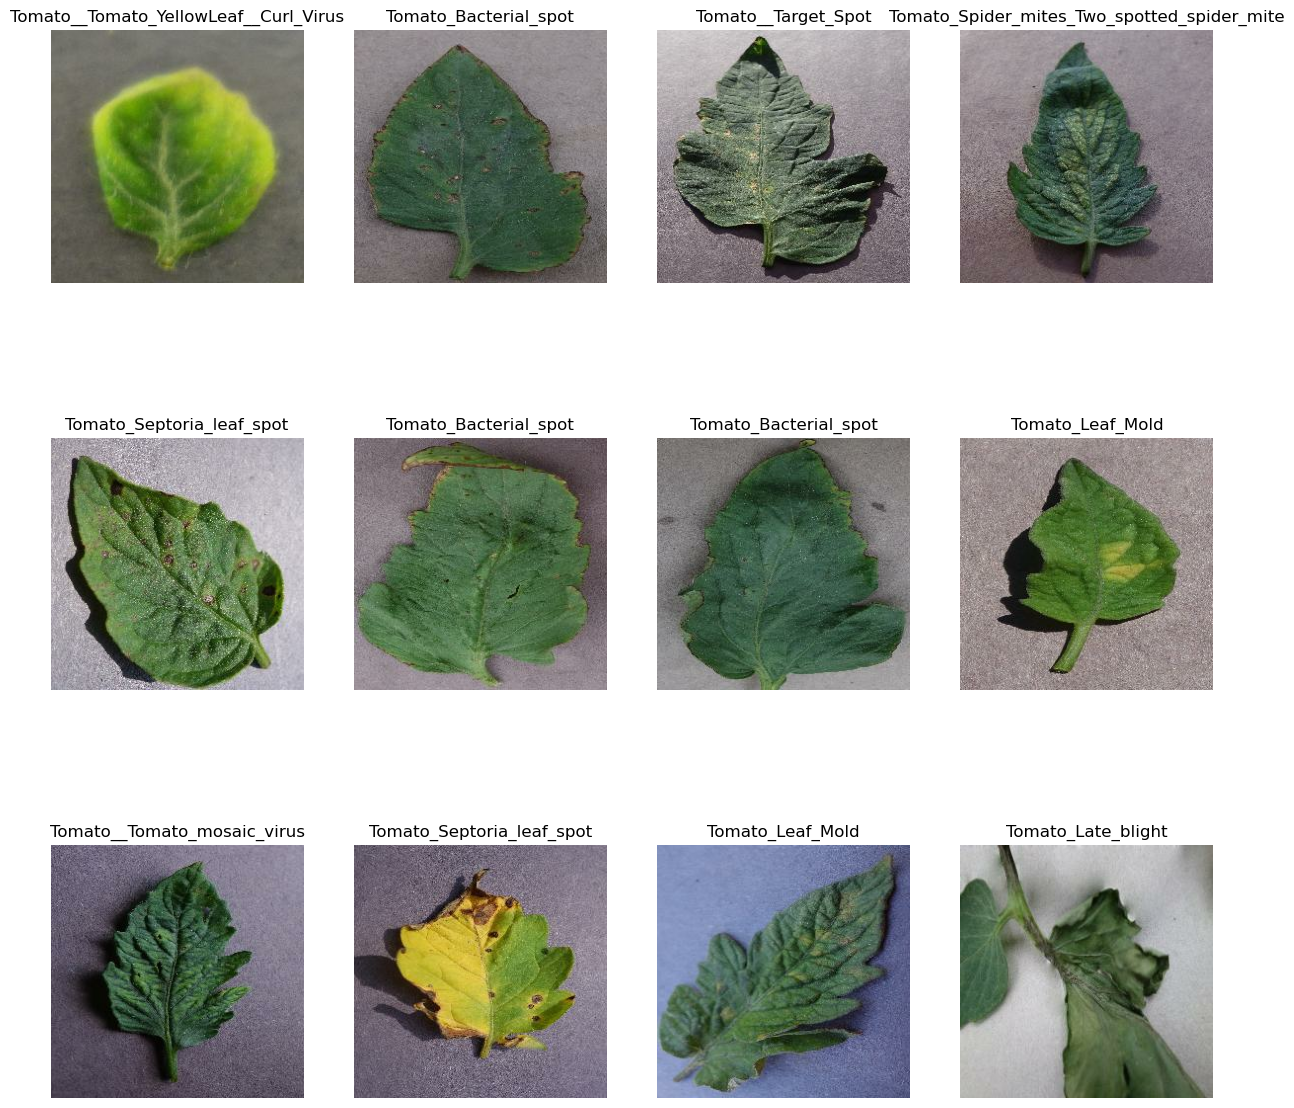

In [8]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        #plt.title(f'label number: {label_batch[0].numpy()} label name:{dataset.class_names[label_batch[0]]}')
        plt.title(dataset.class_names[label_batch[i]])
        plt.axis('off')
    print(image_batch.shape)
    print(label_batch.shape)

In [9]:
len(dataset)

501

In [10]:
def gen_train_val_test_set(dataset,size_train=0.8,size_val=0.1,size_test=0.1, shuffle=True, shuffle_size=10000):
    # Calculate the sizes for your splits
    num_examples = len(dataset)

    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=42)

    num_validation = int(size_val * num_examples)  # 20% for validation
    num_test = int(size_test * num_examples)  # 10% for test
    num_train = num_examples - num_validation - num_test

    # Split the dataset
    train_dataset = dataset.take(num_train)
    validation_dataset = dataset.skip(num_train).take(num_validation)
    test_dataset = dataset.skip(num_train + num_validation).take(num_test)

    return train_dataset,validation_dataset,test_dataset

In [11]:
train,val,test = gen_train_val_test_set(dataset)
print(len(train), len(val), len(test))

401 50 50


In [12]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
resize_an_scale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [32]:
INPUT_SHAPE = (BATCH_SIZE, IMAGE_SIZE[0], IMAGE_SIZE[1],CHANNELS)
N_CLASSES = 10

CNN_model = models.Sequential([
    resize_an_scale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D ((2, 2)), 
    layers.Conv2D(256, (3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'), 
    layers.MaxPooling2D ((2, 2)), 
    layers.Conv2D(64, (3, 3), activation='relu'), 
    layers.MaxPooling2D ((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(N_CLASSES, activation='sigmoid')
])

In [33]:
CNN_model.build(input_shape=INPUT_SHAPE)

In [34]:
CNN_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_67 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_67 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_68 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                

In [35]:
CNN_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history = CNN_model.fit(
    train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val,
)

Epoch 1/10
401/401 [==============================] - 595s 1s/step - loss: 1.7112 - accuracy: 0.3745 - val_loss: 1.3471 - val_accuracy: 0.5019
Epoch 2/10
401/401 [==============================] - 563s 1s/step - loss: 0.9697 - accuracy: 0.6539 - val_loss: 1.0301 - val_accuracy: 0.6519
Epoch 3/10
401/401 [==============================] - 568s 1s/step - loss: 0.6648 - accuracy: 0.7619 - val_loss: 0.7172 - val_accuracy: 0.7444
Epoch 4/10
401/401 [==============================] - 552s 1s/step - loss: 0.5151 - accuracy: 0.8138 - val_loss: 0.5447 - val_accuracy: 0.8094
Epoch 5/10
401/401 [==============================] - 582s 1s/step - loss: 0.4414 - accuracy: 0.8461 - val_loss: 0.5510 - val_accuracy: 0.8044
Epoch 6/10
401/401 [==============================] - 566s 1s/step - loss: 0.3520 - accuracy: 0.8739 - val_loss: 0.4865 - val_accuracy: 0.8331
Epoch 7/10
401/401 [==============================] - 559s 1s/step - loss: 0.3128 - accuracy: 0.8897 - val_loss: 0.5390 - val_accuracy: 0.8106

In [37]:
scores = CNN_model.evaluate(test)

50/50 [==============================] - 29s 387ms/step - loss: 0.2574 - accuracy: 0.9069


In [38]:
print(f'loss: {scores[0]}, acc: {scores[1]}')

loss: 0.2573675811290741, acc: 0.9068750143051147


In [39]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

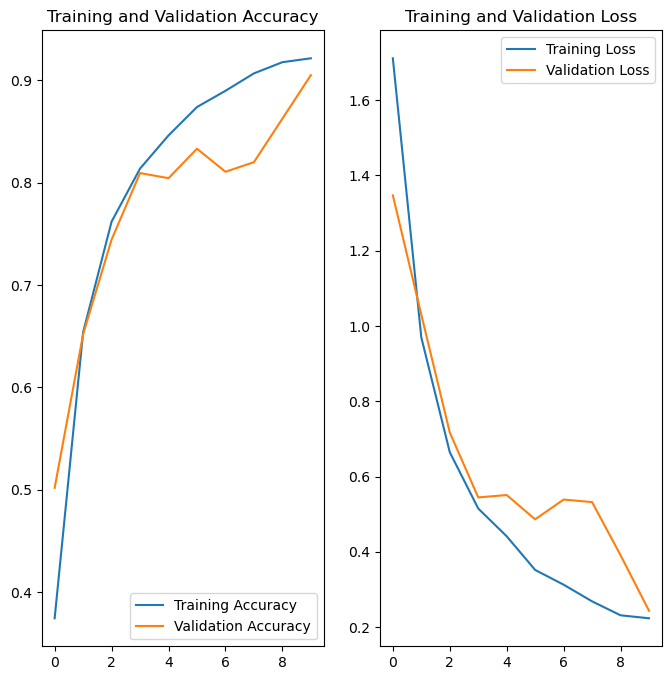

In [41]:
plt.figure(figsize= (8, 8)) 
plt.subplot (1, 2, 1) 
plt.plot(range (EPOCHS), acc, label='Training Accuracy') 
plt.plot(range (EPOCHS), val_acc, label='Validation Accuracy') 
plt.legend(loc='lower right') 
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot (range (EPOCHS), loss, label='Training Loss')
plt.plot (range (EPOCHS), val_loss, label='Validation Loss') 
plt.legend(loc="upper right") 
plt.title('Training and Validation Loss') 
plt.show()

first image to predict
actual label: Tomato__Target_Spot
1/1 [==============================] - 1s 631ms/step
predicted label:  Tomato__Target_Spot


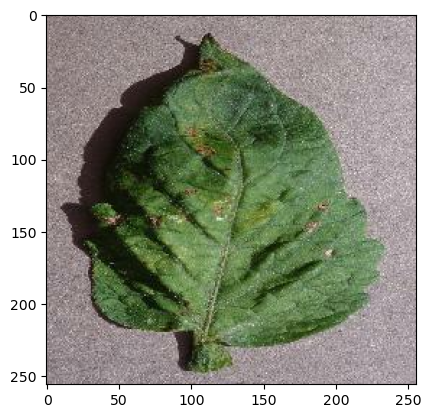

In [42]:
import numpy as np
class_names = dataset.class_names
for images_batch, labels_batch in test.take (1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    batch_prediction = CNN_model.predict(images_batch)
    print("predicted label: ",class_names [np.argmax(batch_prediction[0])])

In [43]:
def predict(model, img) :
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max (predictions [0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 35ms/step


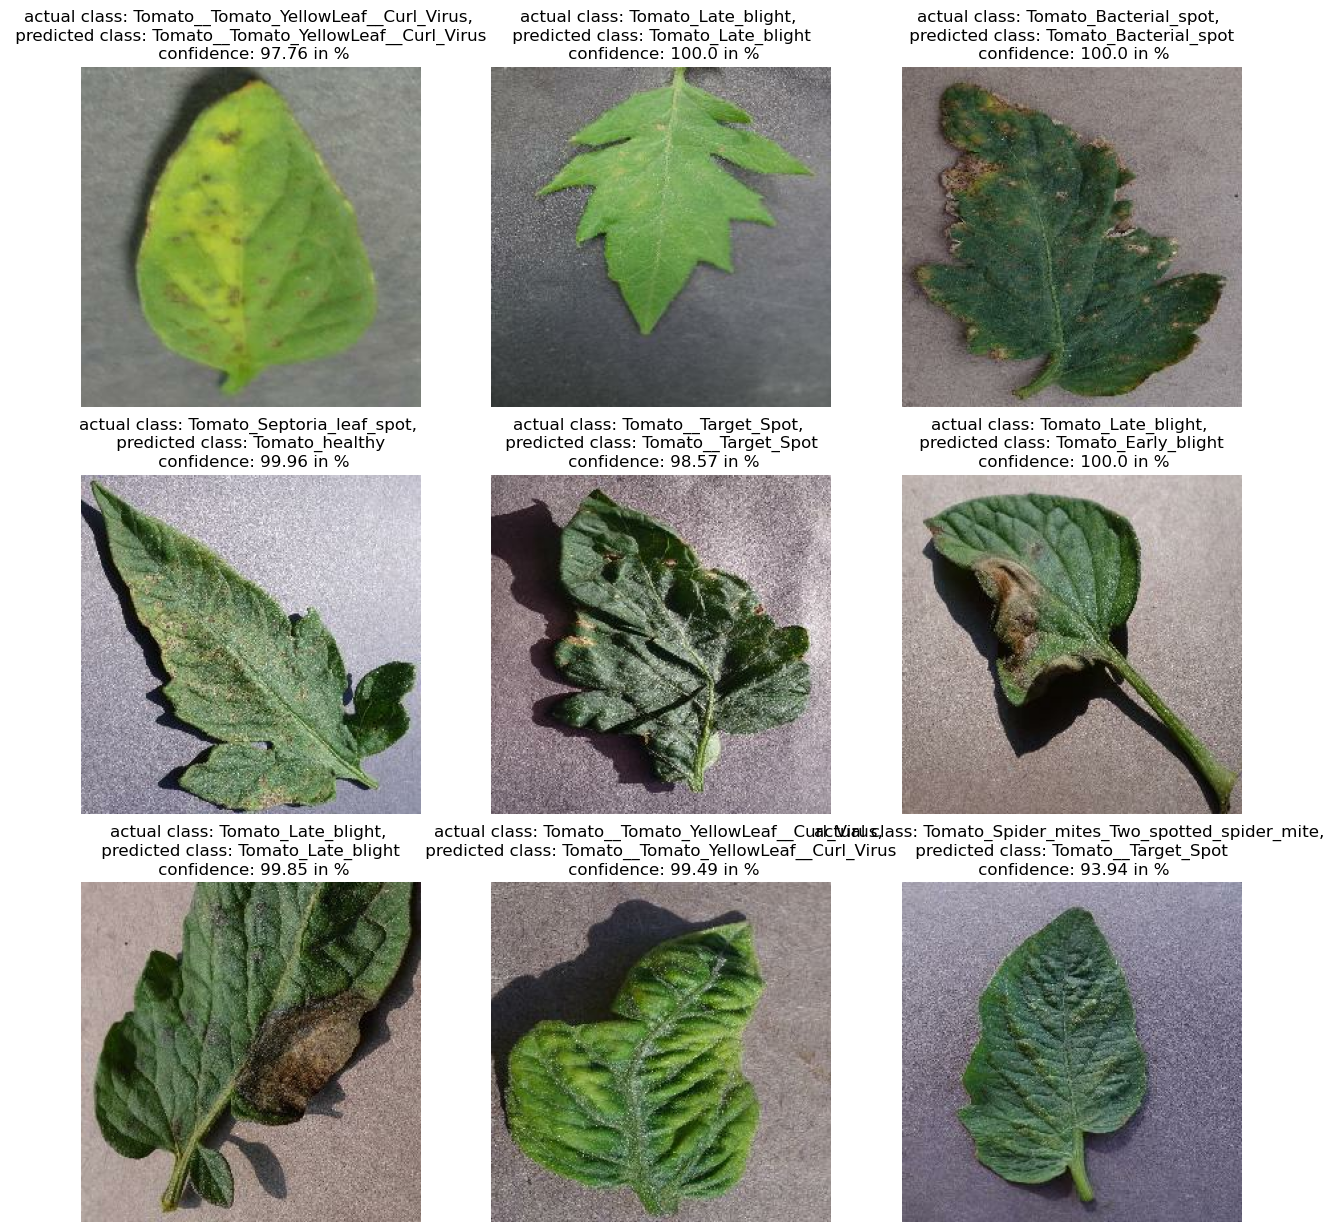

In [44]:
plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range (9):
        ax = plt.subplot (3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(CNN_model, images[i].numpy())
        actual_class = class_names[labels[i]]


        plt.title(f'actual class: {actual_class}, \n predicted class: {predicted_class} \n confidence: {confidence} in %')

        plt.axis("off")

In [45]:
import os
max_model_version = max([int(i.split('_')[1]) if len(i) > 1 else int(i) for i in os.listdir('../saved_models')]) +1
max_model_version
CNN_model.save(f'../saved_models/tomato_model_{max_model_version}')

INFO:tensorflow:Assets written to: ../saved_models/tomato_model_5/assets


INFO:tensorflow:Assets written to: ../saved_models/tomato_model_5/assets
